In [8]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 1.0
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(driver_h,delta_t*beta_k)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))



def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")


        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 200
beta_0 = 0.01
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)

第1步：能量 = -0.76746786 Ha | β_0 = +0.010000
第2步：能量 = -0.76759209 Ha | β_1 = +0.049917
第3步：能量 = -0.76801466 Ha | β_2 = +0.099781
第4步：能量 = -0.76888278 Ha | β_3 = +0.149519
第5步：能量 = -0.77034062 Ha | β_4 = +0.199023
第6步：能量 = -0.77252716 Ha | β_5 = +0.248144
第7步：能量 = -0.77557328 Ha | β_6 = +0.296681
第8步：能量 = -0.77959804 Ha | β_7 = +0.344375
第9步：能量 = -0.78470411 Ha | β_8 = +0.390903
第10步：能量 = -0.79097267 Ha | β_9 = +0.435884
第11步：能量 = -0.79845798 Ha | β_10 = +0.478877
第12步：能量 = -0.80718221 Ha | β_11 = +0.519399
第13步：能量 = -0.81713128 Ha | β_12 = +0.556939
第14步：能量 = -0.82825219 Ha | β_13 = +0.590987
第15步：能量 = -0.84045283 Ha | β_14 = +0.621066
第16步：能量 = -0.85360453 Ha | β_15 = +0.646763
第17步：能量 = -0.86754749 Ha | β_16 = +0.667763
第18步：能量 = -0.88209898 Ha | β_17 = +0.683878
第19步：能量 = -0.89706327 Ha | β_18 = +0.695066
第20步：能量 = -0.91224250 Ha | β_19 = +0.701439
第21步：能量 = -0.92744705 Ha | β_20 = +0.703254
第22步：能量 = -0.94250454 Ha | β_21 = +0.700897
第23步：能量 = -0.95726647 Ha | β_22 = +0.694857
第24步：能量

In [9]:
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0),
    ("IXII", -1.0),
    ("IIXI", -1.0),
    ("IIIX", -1.0),
])

cost_h = SparsePauliOp.from_list([
    ("ZIII", -1.0),
    ("IZII", -1.0),
    ("IIZI", -1.0),
    ("IIIZ", -1.0),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))



def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        print(f"第{i + 1}步：能量 = {energy:.8f} | β_{i} = {beta[i]:+.6f}")


        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 500
beta_0 = 0
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)


第1步：能量 = 0.00000000 | β_0 = +0.000000
第2步：能量 = -0.01378067 | β_1 = +0.479712
第3步：能量 = -0.05485641 | β_2 = +0.957301
第4步：能量 = -0.13582991 | β_3 = +1.427897
第5步：能量 = -0.26692724 | β_4 = +1.880944
第6步：能量 = -0.45353843 | β_5 = +2.298037
第7步：能量 = -0.69325984 | β_6 = +2.652782
第8步：能量 = -0.97392559 | β_7 = +2.914380
第9步：能量 = -1.27465877 | β_8 = +3.055805
第10步：能量 = -1.57084894 | β_9 = +3.064547
第11步：能量 = -1.84117781 | β_10 = +2.950258
第12步：能量 = -2.07286043 | β_11 = +2.743535
第13步：能量 = -2.26258408 | β_12 = +2.485655
第14步：能量 = -2.41388910 | β_13 = +2.215637
第15步：能量 = -2.53352954 | β_14 = +1.961667
第16步：能量 = -2.62871309 | β_15 = +1.739132
第17步：能量 = -2.70569306 | β_16 = +1.553115
第18步：能量 = -2.76935400 | β_17 = +1.402239
第19步：能量 = -2.82329901 | β_18 = +1.281968
第20步：能量 = -2.87010639 | β_19 = +1.186776
第21步：能量 = -2.91159505 | β_20 = +1.111348
第22步：能量 = -2.94904266 | β_21 = +1.051098
第23步：能量 = -2.98334862 | β_22 = +1.002314
第24步：能量 = -3.01515024 | β_23 = +0.962111
第25步：能量 = -3.04490376 | β_24 = +0.92

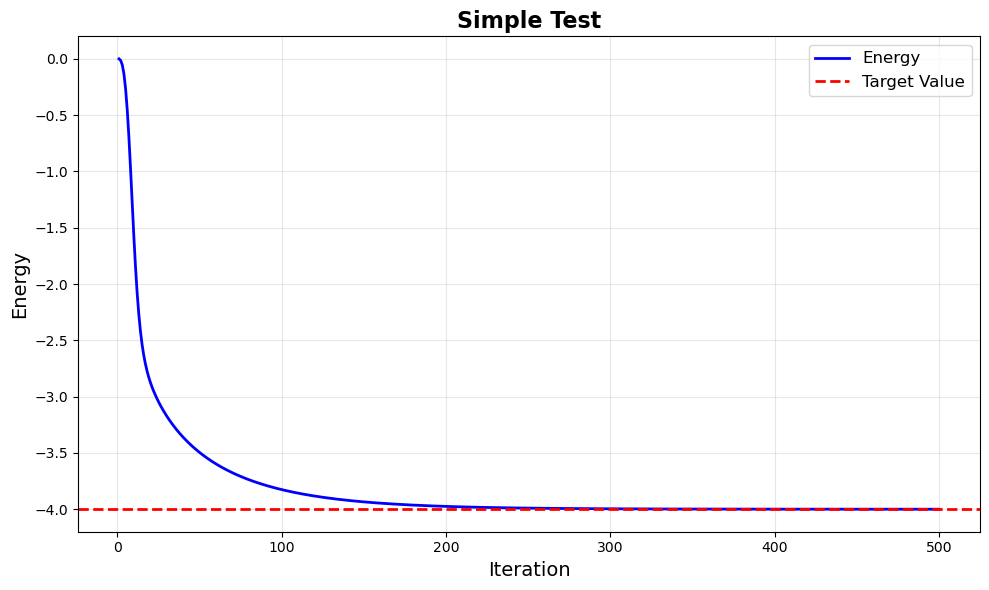

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制能量收敛图
plt.figure(figsize=(10, 6))

# 创建迭代次数数组
iterations = np.arange(1, len(s_energies) + 1)

# 绘制能量曲线
plt.plot(iterations, s_energies, 'b-', linewidth=2, label='Energy')

# 绘制目标值线
target_value = -4
plt.axhline(y=target_value, color='r', linestyle='--', linewidth=2, label='Target Value')

# 设置图表标题和标签
plt.title('Simple Test', fontsize=16, fontweight='bold')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Energy', fontsize=14)

# 添加图例
plt.legend(fontsize=12)

# 添加网格
plt.grid(True, alpha=0.3)

# 设置坐标轴范围（可选，根据数据自动调整）
plt.tight_layout()

# 显示图表
plt.show()

# 如果需要保存图片，可以添加以下代码
# plt.savefig('simple_test.png', dpi=300, bbox_inches='tight')